# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import Dataset, getDataset
import utils as u
import pandas as pd
import seaborn as sns
idx = pd.IndexSlice

# Read data

In [3]:
datasets = {}
datasets['duz boru h'] = pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Düz boru H ", header=None)
datasets['mikrokanatli boru h'] = pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Mikrokanatlı Boru H")
datasets['duz boru dp'] = pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Düz Boru dP")
datasets['mikrokanatli boru dp'] = pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Mikrokanatlı Boru dP")

datasets_processed = {}
datasets_processed['duz boru h'] = getDataset(pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Düz boru H ", header=None))
datasets_processed['mikrokanatli boru h'] = getDataset(pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Mikrokanatlı Boru H", header=None))
datasets_processed['duz boru dp'] = getDataset(pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Düz Boru dP", header=None))
datasets_processed['mikrokanatli boru dp'] = getDataset(pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Mikrokanatlı Boru dP", header=None))

data_h = pd.concat([
    datasets_processed['duz boru h'].assign(dataset='Plain tube h'),
    datasets_processed['mikrokanatli boru h'].assign(dataset='Microfin tube h')
], axis=0, ignore_index=True)


data_dp = pd.concat([
    datasets_processed['duz boru dp'].assign(dataset='Plain tube dp'),
    datasets_processed['mikrokanatli boru dp'].assign(dataset='Microfin tube dp')
], axis=0, ignore_index=True)



# data_h.to_pickle("../data/Boiling ANN data_h.pkl")
# data_dp.to_pickle("../data/Boiling ANN data_dp.pkl")

In [4]:
Xh = data_h.loc[:, idx[['Input Raw', 'Input Calculated'], :]]
yh = data_h['Output']
Xdp = data_dp.loc[:, idx[['Input Raw', 'Input Calculated'], :]]
ydp = data_dp['Output']
# pd.DataFrame(Xh).assign(y=yh).to_csv("../data/Boiling_ANN_data_h.csv", index=False)
# pd.DataFrame(Xdp).assign(y=ydp).to_csv("../data/Boiling_ANN_data_dp.csv", index=False)

In [5]:
# Rename using definitions in the markdown

data_h.T.drop(("Output", "Output 1")).reset_index(drop=True).rename(
    index={
        0: 'Mass flux',
        1: 'Saturation pressure',
        2: 'Heat flux',
        3: 'Quality',
        4: 'Pressure drop',
        # 5: 'Heat transfer coefficient',
        5: 'Reynolds number',
        6: 'Two-phase multiplier',
        7: 'Froude number',
        8: 'Weber number',
        9: 'Bond number',
        10: "Tube type"
    },
).T.assign(y=yh).rename(columns={'y': 'Heat transfer coefficient'}).sample(5).head().style.set_caption("Microfinned and Plain Tubes - h")


,Mass flux,Saturation pressure,Heat flux,Quality,Pressure drop,Reynolds number,Two-phase multiplier,Froude number,Weber number,Bond number,Tube type,Heat transfer coefficient
161,190.393921,488370.000000,15000.000000,0.689015,7682.000000,2275.465891,0.091034,0.277273,26.617714,0.073149,Microfin tube h,5064.821113
159,185.634073,488370.000000,15000.000000,0.552524,5987.000000,3192.310540,0.154071,0.263583,25.303465,0.116771,Microfin tube h,5316.385315
24,190.393921,478417.444477,10322.040210,0.434033,1954.887476,4108.014258,0.234166,0.276250,26.321835,0.169044,Plain tube h,3381.807706
59,380.787842,589967.735857,14763.134560,0.189889,4122.000000,12783.531104,0.754287,1.149031,118.741742,0.488949,Plain tube h,3852.734881
163,285.590881,488370.000000,15000.000000,0.319112,8012.000000,7473.056256,0.368438,0.623865,59.889857,0.253458,Microfin tube h,5093.978474


In [6]:
# Rename using definitions in the markdown

data_dp.T.drop(("Output", "Output 1")).reset_index(drop=True).rename(
    index={
        0: 'Mass flux',
        1: 'Saturation pressure',
        2: 'Heat flux',
        3: 'Quality',
        # 4: 'Pressure drop',
        4: 'Heat transfer coefficient',
        5: 'Reynolds number',
        6: 'Two-phase multiplier',
        7: 'Froude number',
        8: 'Weber number',
        9: 'Bond number',
        10: "Tube type"
    },
).T.assign(y=ydp).rename(columns={'y': 'Pressure drop'}).sample(5).head().style.set_caption("Microfinned and Plain Tubes - $\Delta P$")


,Mass flux,Saturation pressure,Heat flux,Quality,Heat transfer coefficient,Reynolds number,Two-phase multiplier,Froude number,Weber number,Bond number,Tube type,Pressure drop
13,299.870425,587429.714203,10290.371384,0.709044,4671.977866,3609.205393,0.091496,0.711996,73.445504,0.074941,Plain tube dp,10719.000000
28,285.590881,477045.128052,10270.481568,0.359390,3380.785514,6966.995116,0.309814,0.621264,59.132928,0.216739,Plain tube dp,4478.000000
26,195.153769,478733.774160,10209.344838,0.569122,3432.334129,3206.520250,0.143601,0.290282,27.664727,0.109461,Plain tube dp,3866.815510
55,295.110577,588389.868972,14873.853178,0.400000,4039.671541,6499.446509,0.229135,0.689798,71.203414,0.169506,Plain tube dp,5824.000000
92,190.393921,607890.000000,10169.938661,0.412561,5468.893375,4692.177461,0.285149,0.288958,30.238508,0.206611,Microfin tube dp,4483.000000


# HTP

In [7]:
htp = u.Dataset(data=data_h, X=Xh, y=yh)
htp.setRenameFunc(u.renameH)
htp.setColNames(u.H_NAMES)
htp.setDec(u.getDecPipeline())
htp.decompose()
htp.displayDecompositionResults()
htp.setClusterer(u.getClusterer())
htp.setCategories()
htp.split(random_state=42, test_size=0.2)
htp.defineCats()
htp.setScoring(u.SCORING)
# htp.addModel(u.getDummy(), 'Dummy')
# htp.addModel(u.getDummy(), 'Mummy')
htp.addModel(u.getANN(), 'ANN')
htp.addModel(u.getLwr(), 'LWR')
htp.addModel(u.getGBM(), 'GBM')


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits


EDA

In [8]:
display(htp.displayEDA())


c:\Users\berk_\miniconda3\envs\cons1\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Decomposition

In [9]:
display(htp.displayDecompositionResults())

,PCA1,PCA2
Mass flux,0.371403,0.336128
Saturation pressure,0.035643,-0.027975
Heat flux,-0.031835,0.044657
Quality,-0.338355,0.365280
Pressure drop,0.072366,0.519421
Reynolds number,0.456948,-0.059758
Two-phase multiplier,0.348064,-0.364637
Froude number,0.379246,0.325789
Weber number,0.380145,0.321854
Bond number,0.348953,-0.367088


Clusters

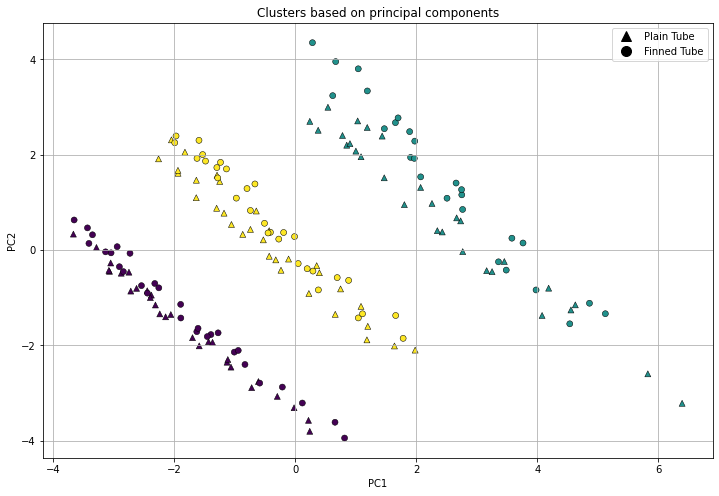

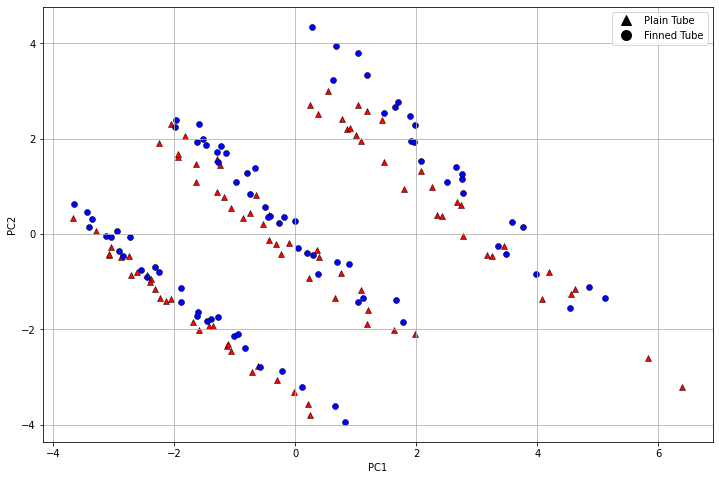

In [10]:
htp.visualizeClusters()

Test Results

In [11]:
htp.displayAllModelTestResults()

,ANN,LWR,GBM
R2,0.611838,0.849524,0.720755
RMSE,729.422772,454.156983,618.679613
MAE,458.809666,350.684576,478.545368
MAPE,0.086640,0.068111,0.098622
Bias%,0.008683,-0.005086,0.005344
WAPE%,0.101735,0.070635,0.100145
Pearson-R,0.729273,0.850604,0.721381


Plot Predictions

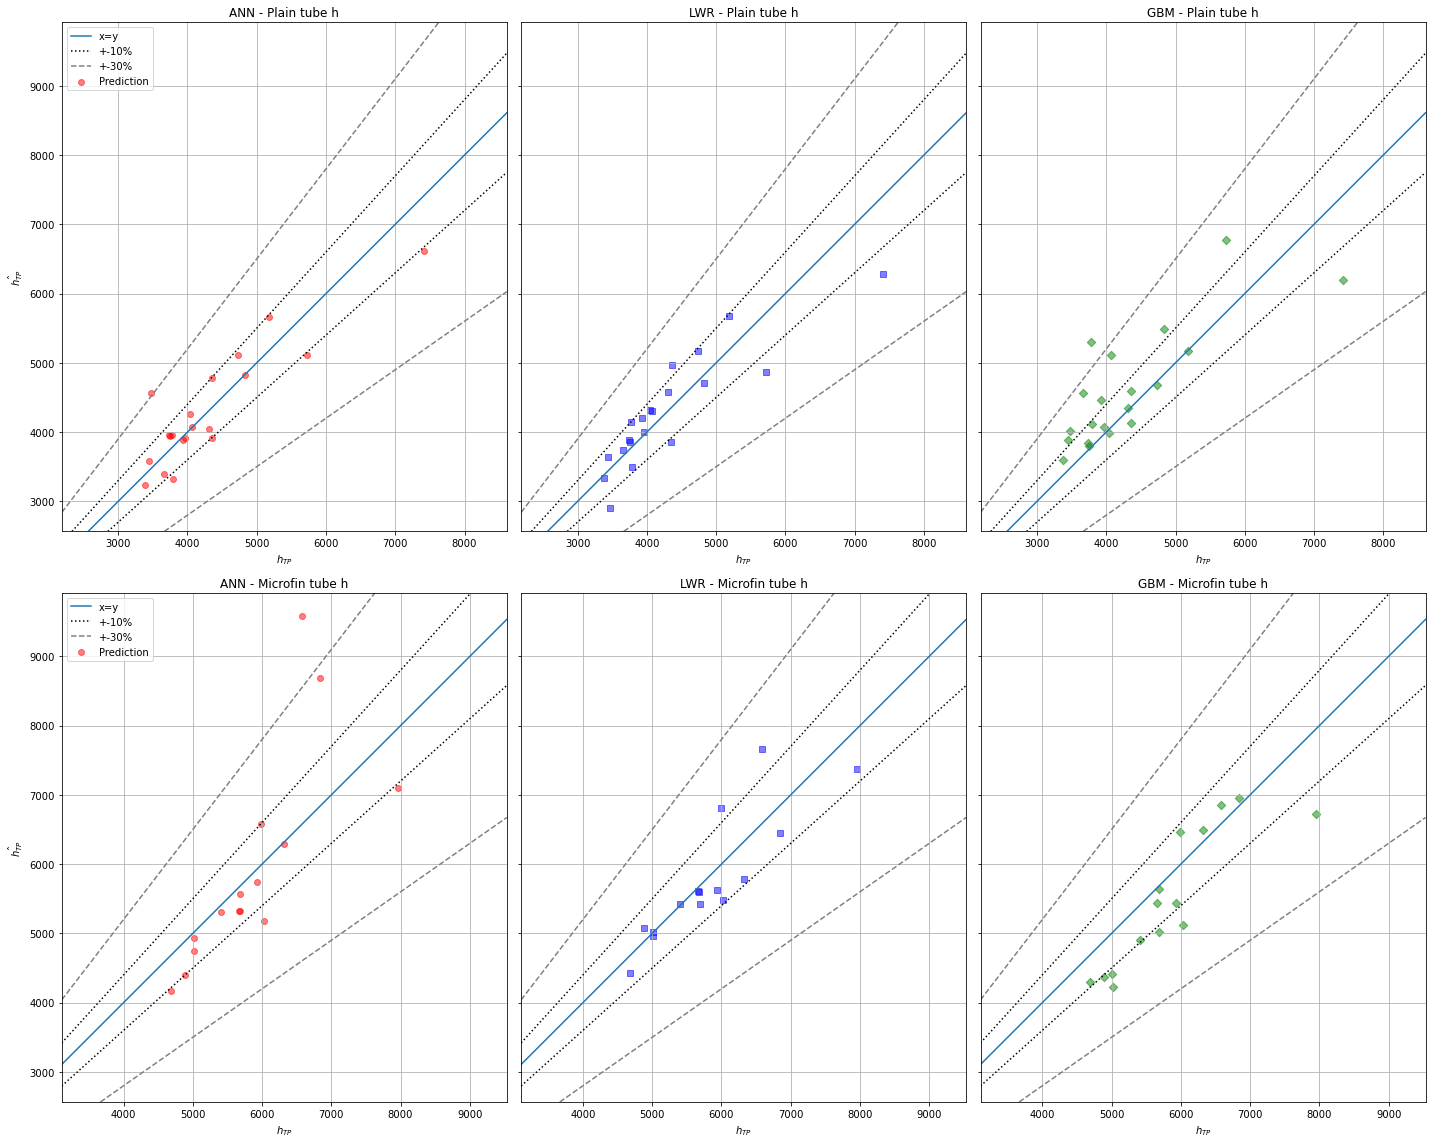

In [12]:
htp.plot_predictions()

Pair plots

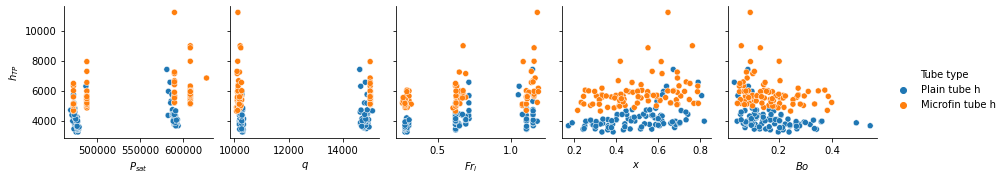

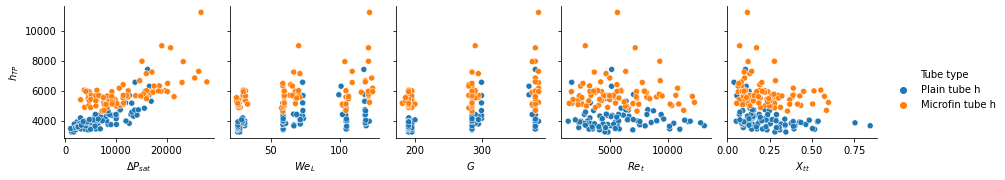

In [13]:
htp.displayPairs(target_var='Heat transfer coefficient', row_len=5)

Histograms

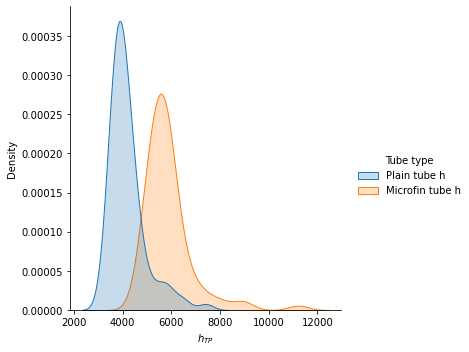

In [14]:
htp.displayHistogram(target_var='Heat transfer coefficient')

Params results

In [15]:
for m in htp.models_cv:
    display(u.process_ann_results(htp.models_cv[m], m)[0].T)

ANN,"((regressor activation, logistic), (regressor hidden_layer_sizes, (128, 64, 32, 16, 8)), (regressor tol, 1e-05))","((regressor activation, logistic), (regressor hidden_layer_sizes, (10, 10)), (regressor tol, 1e-05))","((regressor activation, relu), (regressor hidden_layer_sizes, (10, 10)), (regressor tol, 1e-05))","((regressor activation, logistic), (regressor hidden_layer_sizes, (50, 50)), (regressor tol, 1e-05))","((regressor activation, logistic), (regressor hidden_layer_sizes, (20, 20)), (regressor tol, 1e-05))","((regressor activation, relu), (regressor hidden_layer_sizes, (20, 20)), (regressor tol, 1e-05))","((regressor activation, relu), (regressor hidden_layer_sizes, (128, 64, 32, 16, 8)), (regressor tol, 1e-05))","((regressor activation, relu), (regressor hidden_layer_sizes, (50, 50)), (regressor tol, 1e-05))"
fit_time,0.948629,3.060414,2.027972,2.672515,2.842595,1.326747,1.330747,1.041151
score_time,0.010336,0.005336,0.009000,0.005334,0.008666,0.009003,0.009669,0.010671
test_R2,-0.009681,0.764788,0.772834,0.772999,0.773092,0.790231,0.806611,0.808049
train_R2,-0.000274,0.965017,0.983542,0.982082,0.973811,0.988896,0.998554,0.995527
test_RMSE,-1217.465850,-544.296392,-578.112035,-553.772869,-553.698744,-520.826969,-516.995440,-516.423964
train_RMSE,-1223.691052,-228.167360,-156.689540,-163.017404,-197.577397,-128.989298,-46.114746,-80.404150
test_MAE,-957.910201,-379.559492,-437.455763,-407.224210,-397.299068,-385.095000,-370.185727,-383.316113
train_MAE,-952.408567,-178.050202,-113.847419,-116.683051,-146.458092,-91.935565,-24.873300,-48.502334
test_MAPE,-0.197103,-0.073035,-0.088383,-0.082461,-0.079557,-0.076902,-0.071649,-0.076774
train_MAPE,-0.195983,-0.037026,-0.023855,-0.024532,-0.030172,-0.019445,-0.005211,-0.010155


LWR,"((regressor gamma, 0.7), (regressor n_neighbors, 5))","((regressor gamma, 3), (regressor n_neighbors, 5))","((regressor gamma, 2), (regressor n_neighbors, 5))","((regressor gamma, 1), (regressor n_neighbors, 5))","((regressor gamma, 3), (regressor n_neighbors, 10))","((regressor gamma, 2), (regressor n_neighbors, 10))","((regressor gamma, 1), (regressor n_neighbors, 10))","((regressor gamma, 0.7), (regressor n_neighbors, 10))","((regressor gamma, 3), (regressor n_neighbors, 15))","((regressor gamma, 3), (regressor n_neighbors, 20))","((regressor gamma, 2), (regressor n_neighbors, 15))","((regressor gamma, 0.7), (regressor n_neighbors, 20))","((regressor gamma, 0.7), (regressor n_neighbors, 15))","((regressor gamma, 1), (regressor n_neighbors, 15))","((regressor gamma, 1), (regressor n_neighbors, 20))","((regressor gamma, 2), (regressor n_neighbors, 20))"
fit_time,0.007668,0.005334,0.004666,0.005002,0.004668,0.005001,0.004672,0.005669,0.005680,0.005001,0.004335,0.005001,0.005336,0.005169,0.005665,0.005670
score_time,0.057015,0.039353,0.039172,0.042168,0.040838,0.039837,0.039174,0.044838,0.044565,0.041682,0.041850,0.048352,0.047593,0.043058,0.048509,0.048029
test_R2,-1.979013,-1.510569,-1.485916,-1.248471,0.079013,0.289151,0.404530,0.423290,0.625325,0.641175,0.670396,0.672703,0.675171,0.678596,0.679505,0.680406
test_RMSE,-1838.670265,-1742.177564,-1743.298776,-1663.403587,-985.559678,-896.515558,-842.642111,-834.024064,-700.762887,-685.823347,-658.122540,-662.909596,-653.151951,-649.220104,-654.577211,-650.479974
test_MAE,-978.932498,-958.514012,-978.421895,-952.048120,-577.323499,-548.817926,-528.675596,-525.240088,-446.921697,-425.282487,-418.515795,-435.113348,-429.762638,-420.465356,-420.174360,-403.811553
test_MAPE,-0.189424,-0.183189,-0.185002,-0.178430,-0.113243,-0.107260,-0.102575,-0.101707,-0.085646,-0.081625,-0.079996,-0.083769,-0.082242,-0.080327,-0.080582,-0.077172
test_Bias%,0.042451,0.031814,0.019721,0.043840,-0.003644,-0.005612,-0.008612,-0.009960,-0.007765,-0.007251,-0.010458,-0.022883,-0.020516,-0.017479,-0.019399,-0.010810
test_WAPE%,-0.125745,-0.158850,-0.182002,-0.161604,-0.100778,-0.100138,-0.099809,-0.100064,-0.089954,-0.085928,-0.084802,-0.088016,-0.087528,-0.085530,-0.084914,-0.081545
test_Pearson-R,0.172486,0.159947,0.181922,0.169047,0.552557,0.588969,0.614849,0.619877,0.684526,0.698137,0.717977,0.725664,0.731661,0.731078,0.728270,0.724199


GBM,"((regressor reg_alpha, 3),)","((regressor reg_alpha, 0.5),)","((regressor reg_alpha, 0.1),)","((regressor reg_alpha, 0),)","((regressor reg_alpha, 2),)","((regressor reg_alpha, 1),)","((regressor reg_alpha, 5),)","((regressor reg_alpha, 4),)","((regressor reg_alpha, 10),)"
fit_time,0.025526,0.025331,0.019679,0.015335,0.023686,0.025001,0.024668,0.024001,0.022665
score_time,0.007999,0.007665,0.006005,0.005836,0.007509,0.007339,0.008667,0.007332,0.006666
test_R2,0.582143,0.583253,0.583254,0.583254,0.583500,0.583502,0.583707,0.583709,0.585458
test_RMSE,-782.180046,-781.137024,-781.135876,-781.135589,-780.874639,-780.871968,-780.882719,-780.881114,-779.089532
test_MAE,-561.931340,-560.708651,-560.705326,-560.704496,-560.992348,-560.984164,-558.164355,-558.156716,-561.565998
test_MAPE,-0.110227,-0.109958,-0.109958,-0.109957,-0.110024,-0.110023,-0.109254,-0.109253,-0.110376
test_Bias%,-0.005073,-0.005235,-0.005235,-0.005235,-0.005388,-0.005388,-0.004575,-0.004575,-0.006288
test_WAPE%,-0.113233,-0.113006,-0.113006,-0.113006,-0.113098,-0.113097,-0.112452,-0.112451,-0.113393
test_Pearson-R,0.622422,0.623164,0.623166,0.623166,0.623330,0.623334,0.624424,0.624428,0.625535


# DP

In [16]:
dp = u.Dataset(data=data_dp, X=Xdp, y=ydp)
dp.setRenameFunc(u.renameDP)
dp.setColNames(u.DP_NAMES)
dp.setDec(u.getDecPipeline())
dp.decompose()
dp.displayDecompositionResults()
dp.setClusterer(u.getClusterer())
dp.setCategories()
dp.split(random_state=42, test_size=0.2)
dp.defineCats()
dp.setScoring(u.SCORING)
# dp.addModel(u.getDummy(), 'Dummy')
# dp.addModel(u.getDummy(), 'Mummy')
dp.addModel(u.getANN(), 'ANN')
dp.addModel(u.getLwr(), 'LWR')
dp.addModel(u.getGBM(), 'GBM')


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits


EDA

In [17]:
dp.displayEDA()

c:\Users\berk_\miniconda3\envs\cons1\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Decomposition

In [18]:
dp.displayDecompositionResults()

,PCA1,PCA2
Mass flux,0.356427,0.382785
Saturation pressure,0.036562,0.039049
Heat flux,-0.033376,0.046485
Quality,-0.354867,0.371620
Heat transfer coefficient,0.000527,0.399495
Reynolds number,0.459966,-0.030665
Two-phase multiplier,0.364303,-0.364237
Froude number,0.364743,0.376505
Weber number,0.365797,0.378266
Bond number,0.365306,-0.365571


Clusters

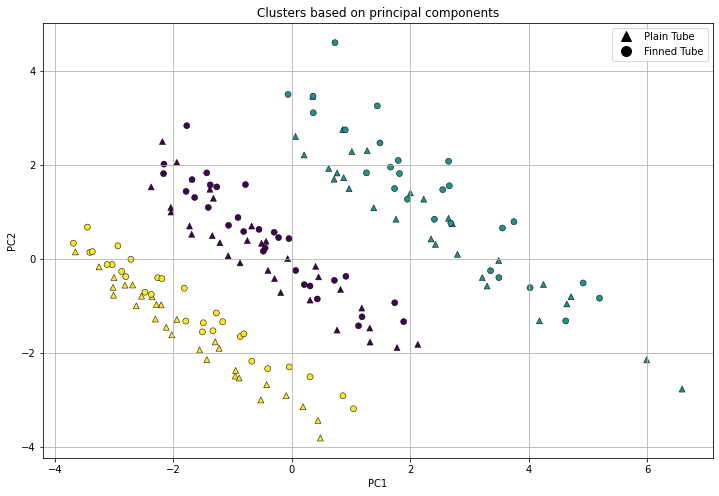

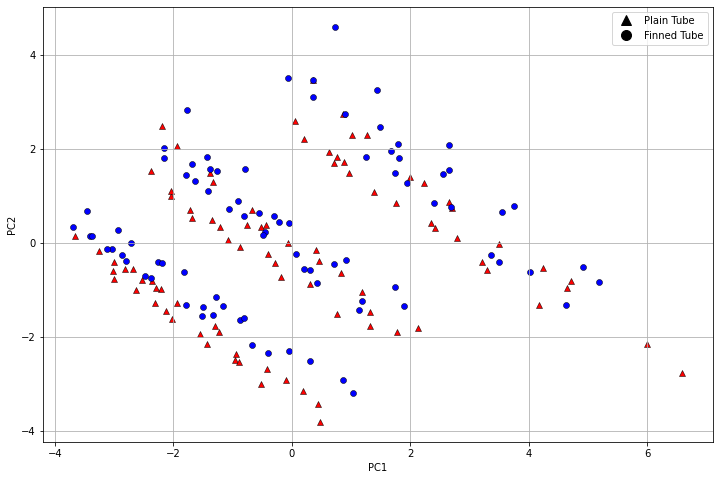

In [19]:
dp.visualizeClusters(fil1='Plain tube dp', fil2='Microfin tube dp')

Test results

In [20]:
dp.displayAllModelTestResults()

,ANN,LWR,GBM
R2,0.868678,0.890873,0.888925
RMSE,2191.498846,1997.743085,2015.494754
MAE,1274.242187,1179.350101,1351.994148
MAPE,0.137099,0.126541,0.155206
Bias%,0.012669,0.038111,-0.008072
WAPE%,0.124633,0.121481,0.137713
Pearson-R,0.869608,0.895021,0.891710


Display predictions

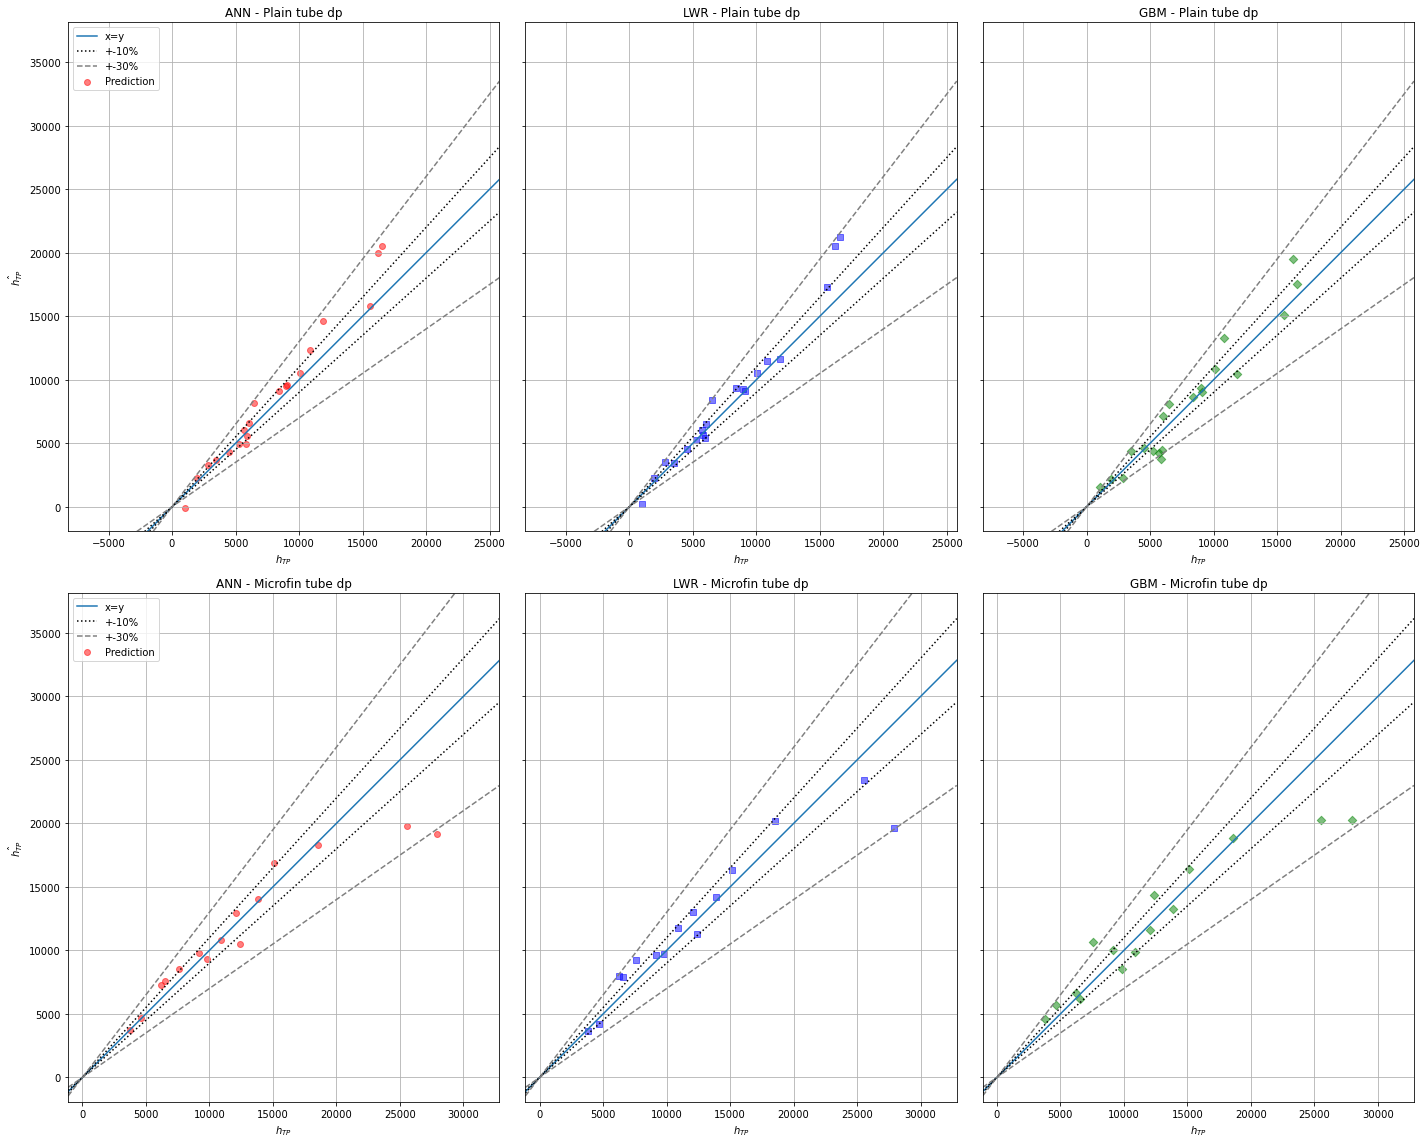

In [21]:
dp.plot_predictions()

Pair plots

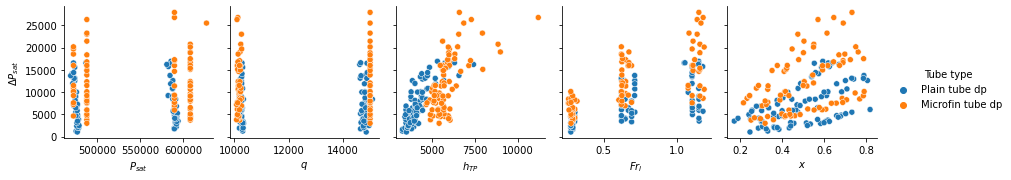

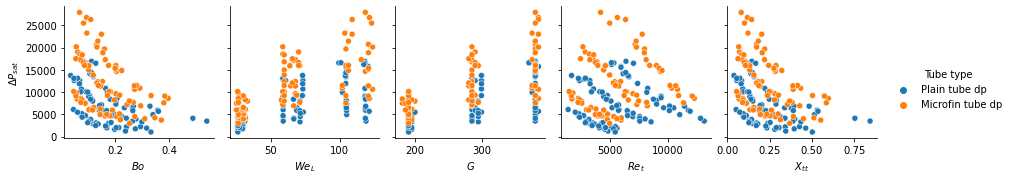

In [22]:
dp.displayPairs(target_var='Pressure drop', row_len=5)

Histograms

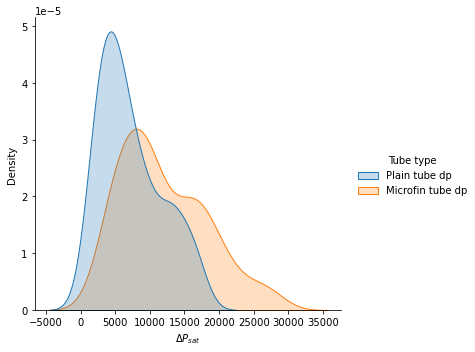

In [23]:
dp.displayHistogram(target_var='Pressure drop')

Params Results

In [24]:
for m in dp.models_cv:
    display(u.process_ann_results(dp.models_cv[m], m)[0].T)

ANN,"((regressor activation, logistic), (regressor hidden_layer_sizes, (128, 64, 32, 16, 8)), (regressor tol, 1e-05))","((regressor activation, logistic), (regressor hidden_layer_sizes, (10, 10)), (regressor tol, 1e-05))","((regressor activation, logistic), (regressor hidden_layer_sizes, (20, 20)), (regressor tol, 1e-05))","((regressor activation, logistic), (regressor hidden_layer_sizes, (50, 50)), (regressor tol, 1e-05))","((regressor activation, relu), (regressor hidden_layer_sizes, (10, 10)), (regressor tol, 1e-05))","((regressor activation, relu), (regressor hidden_layer_sizes, (20, 20)), (regressor tol, 1e-05))","((regressor activation, relu), (regressor hidden_layer_sizes, (128, 64, 32, 16, 8)), (regressor tol, 1e-05))","((regressor activation, relu), (regressor hidden_layer_sizes, (50, 50)), (regressor tol, 1e-05))"
fit_time,1.070517,1.513015,1.141858,1.650930,0.933611,0.667691,1.208694,0.793744
score_time,0.008174,0.008339,0.011672,0.005682,0.011001,0.010334,0.010671,0.009670
test_R2,-0.012864,0.909760,0.913150,0.914520,0.916683,0.917968,0.920119,0.923845
train_R2,-0.000209,0.957778,0.958986,0.977694,0.980777,0.983553,0.998005,0.996503
test_RMSE,-5780.137689,-1693.136987,-1647.856188,-1644.510299,-1628.399458,-1592.719851,-1584.156180,-1552.989298
train_RMSE,-5770.773469,-1175.667565,-1161.775762,-859.938992,-796.022685,-734.096566,-257.451438,-332.117491
test_MAE,-4784.355303,-1222.194825,-1196.447740,-1108.168184,-1159.453138,-1132.490492,-1112.886073,-1090.872449
train_MAE,-4747.077316,-853.567153,-859.812884,-621.619587,-584.823046,-515.364161,-166.983633,-215.497595
test_MAPE,-0.831943,-0.138759,-0.136523,-0.130065,-0.141779,-0.139401,-0.125864,-0.126969
train_MAPE,-0.824513,-0.108450,-0.109721,-0.080125,-0.076526,-0.068351,-0.023079,-0.026568


LWR,"((regressor gamma, 3), (regressor n_neighbors, 5))","((regressor gamma, 1), (regressor n_neighbors, 5))","((regressor gamma, 2), (regressor n_neighbors, 5))","((regressor gamma, 0.7), (regressor n_neighbors, 5))","((regressor gamma, 3), (regressor n_neighbors, 10))","((regressor gamma, 2), (regressor n_neighbors, 10))","((regressor gamma, 1), (regressor n_neighbors, 10))","((regressor gamma, 0.7), (regressor n_neighbors, 10))","((regressor gamma, 3), (regressor n_neighbors, 15))","((regressor gamma, 2), (regressor n_neighbors, 15))","((regressor gamma, 0.7), (regressor n_neighbors, 15))","((regressor gamma, 1), (regressor n_neighbors, 15))","((regressor gamma, 3), (regressor n_neighbors, 20))","((regressor gamma, 2), (regressor n_neighbors, 20))","((regressor gamma, 1), (regressor n_neighbors, 20))","((regressor gamma, 0.7), (regressor n_neighbors, 20))"
fit_time,0.005336,0.005668,0.005172,0.006331,0.004672,0.006001,0.004668,0.005671,0.005334,0.004423,0.004666,0.004999,0.004999,0.004999,0.004666,0.005671
score_time,0.043308,0.040838,0.044001,0.057926,0.041169,0.042258,0.041346,0.041342,0.040896,0.041341,0.040844,0.043507,0.041182,0.042160,0.040344,0.044732
test_R2,0.308570,0.485621,0.569831,0.662073,0.811777,0.819229,0.823913,0.824246,0.873291,0.881887,0.886193,0.886375,0.904604,0.912787,0.918272,0.918288
test_RMSE,-4276.876776,-3536.997924,-3350.529278,-3038.810966,-2277.263391,-2226.560703,-2183.045992,-2173.900081,-1829.719273,-1763.664844,-1749.714367,-1738.938150,-1650.777341,-1588.523855,-1559.056609,-1568.864694
test_MAE,-2414.952200,-2165.529415,-2145.603742,-2030.523860,-1469.429172,-1427.002438,-1426.815439,-1443.469318,-1219.747391,-1155.311412,-1164.079774,-1152.462211,-1066.334917,-1035.633908,-1069.934405,-1100.089640
test_MAPE,-0.292023,-0.259146,-0.255553,-0.245473,-0.170544,-0.166127,-0.172518,-0.178390,-0.143727,-0.140517,-0.150509,-0.146510,-0.126606,-0.126337,-0.136144,-0.141945
test_Bias%,-0.096243,-0.071205,-0.062024,-0.058222,-0.036073,-0.038466,-0.039350,-0.039227,-0.042828,-0.038985,-0.032683,-0.034123,-0.027828,-0.023902,-0.020856,-0.020282
test_WAPE%,-0.306607,-0.277061,-0.250419,-0.220490,-0.164461,-0.160066,-0.159387,-0.160628,-0.137184,-0.130275,-0.130308,-0.129356,-0.115897,-0.111713,-0.113838,-0.116488
test_Pearson-R,0.727608,0.772385,0.787884,0.818579,0.871716,0.875768,0.878864,0.879397,0.925897,0.929685,0.929463,0.930374,0.938455,0.942052,0.944650,0.944576


GBM,"((regressor reg_alpha, 1),)","((regressor reg_alpha, 0.5),)","((regressor reg_alpha, 0.1),)","((regressor reg_alpha, 0),)","((regressor reg_alpha, 10),)","((regressor reg_alpha, 5),)","((regressor reg_alpha, 4),)","((regressor reg_alpha, 3),)","((regressor reg_alpha, 2),)"
fit_time,0.022664,0.025674,0.020840,0.014512,0.022013,0.026001,0.023994,0.022096,0.024714
score_time,0.008001,0.008659,0.008001,0.005838,0.005333,0.007333,0.008334,0.007342,0.008047
test_R2,0.858742,0.858742,0.858743,0.858743,0.859054,0.859357,0.859358,0.859358,0.859359
test_RMSE,-2124.635211,-2124.632873,-2124.631001,-2124.630533,-2123.277425,-2120.738934,-2120.734191,-2120.729453,-2120.724716
test_MAE,-1558.975888,-1558.974081,-1558.972633,-1558.972272,-1553.545108,-1555.000334,-1554.996268,-1554.992205,-1554.988140
test_MAPE,-0.189603,-0.189603,-0.189603,-0.189603,-0.188542,-0.189209,-0.189209,-0.189209,-0.189209
test_Bias%,-0.001318,-0.001318,-0.001318,-0.001319,-0.000565,-0.000952,-0.000953,-0.000954,-0.000955
test_WAPE%,-0.173941,-0.173940,-0.173940,-0.173940,-0.173241,-0.173415,-0.173415,-0.173415,-0.173415
test_Pearson-R,0.890744,0.890744,0.890744,0.890743,0.891360,0.891056,0.891056,0.891055,0.891055


# Extrapolation analysis
In this section, we demonstrate the selected models' strength for making accurate estimations outside observed ranges during the experiment.

Extrapolation performance analysis is conducted by following approach: clusters are identified in principal component space through fitting a Gaussian Mixture Model (GMM), and a Ledoit-Wolf (LW) covariance estimator is fitted separately to each identified cluster again in principal component space.

Samples to be used for extrapolation are then determined by Mahalanobis distance estimations coming from LW estimators fitted on each cluster. 10 samples with the highest Mahalanobis distance are then held out for test and the rest of the samples are used for training the models.

## HTP

In [25]:
extra_htp = u.OutlierDataset(data=data_h, X=Xh, y=yh)
extra_htp.setRenameFunc(u.renameH)
extra_htp.setColNames(u.H_NAMES)
extra_htp.setDec(u.getDecPipeline())
extra_htp.decompose()
extra_htp.setClusterer(u.getClusterer())
extra_htp.setCategories()
extra_htp.split()
extra_htp.setScoring(u.SCORING)



Visualize outliers

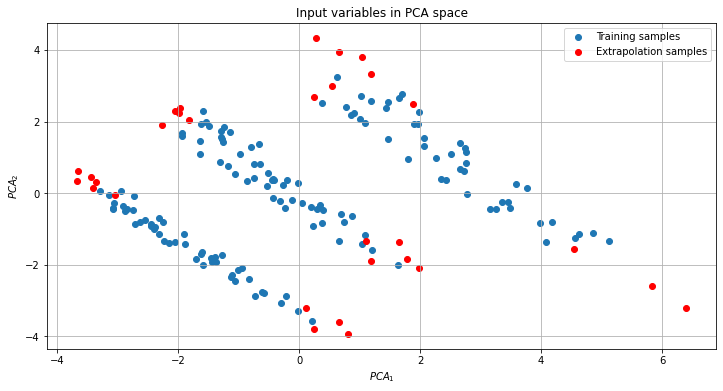

In [26]:
extra_htp.visualizeOutliers()

Extrapolation samples identified using Mahalanobis distances are highlighted with red in figure. Note that these samples are located in the outermost of their respective distributions, and represent extreme input values.

Fit models

In [27]:
extra_htp.addModel(u.getANN(), 'ANN')
extra_htp.addModel(u.getLwr(), 'LWR')
extra_htp.addModel(u.getGBM(), 'GBM')

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits


Test results

In [28]:
extra_htp.displayAllModelTestResults()

,ANN,LWR,GBM
R2,0.688588,0.758915,0.504232
RMSE,824.942314,725.841152,1040.867710
MAE,654.521541,534.330825,683.860666
MAPE,0.111537,0.089451,0.107409
Bias%,-0.051879,-0.061961,-0.100666
WAPE%,0.111696,0.087985,0.110083
Pearson-R,0.750752,0.818665,0.695456


Prediction Plots

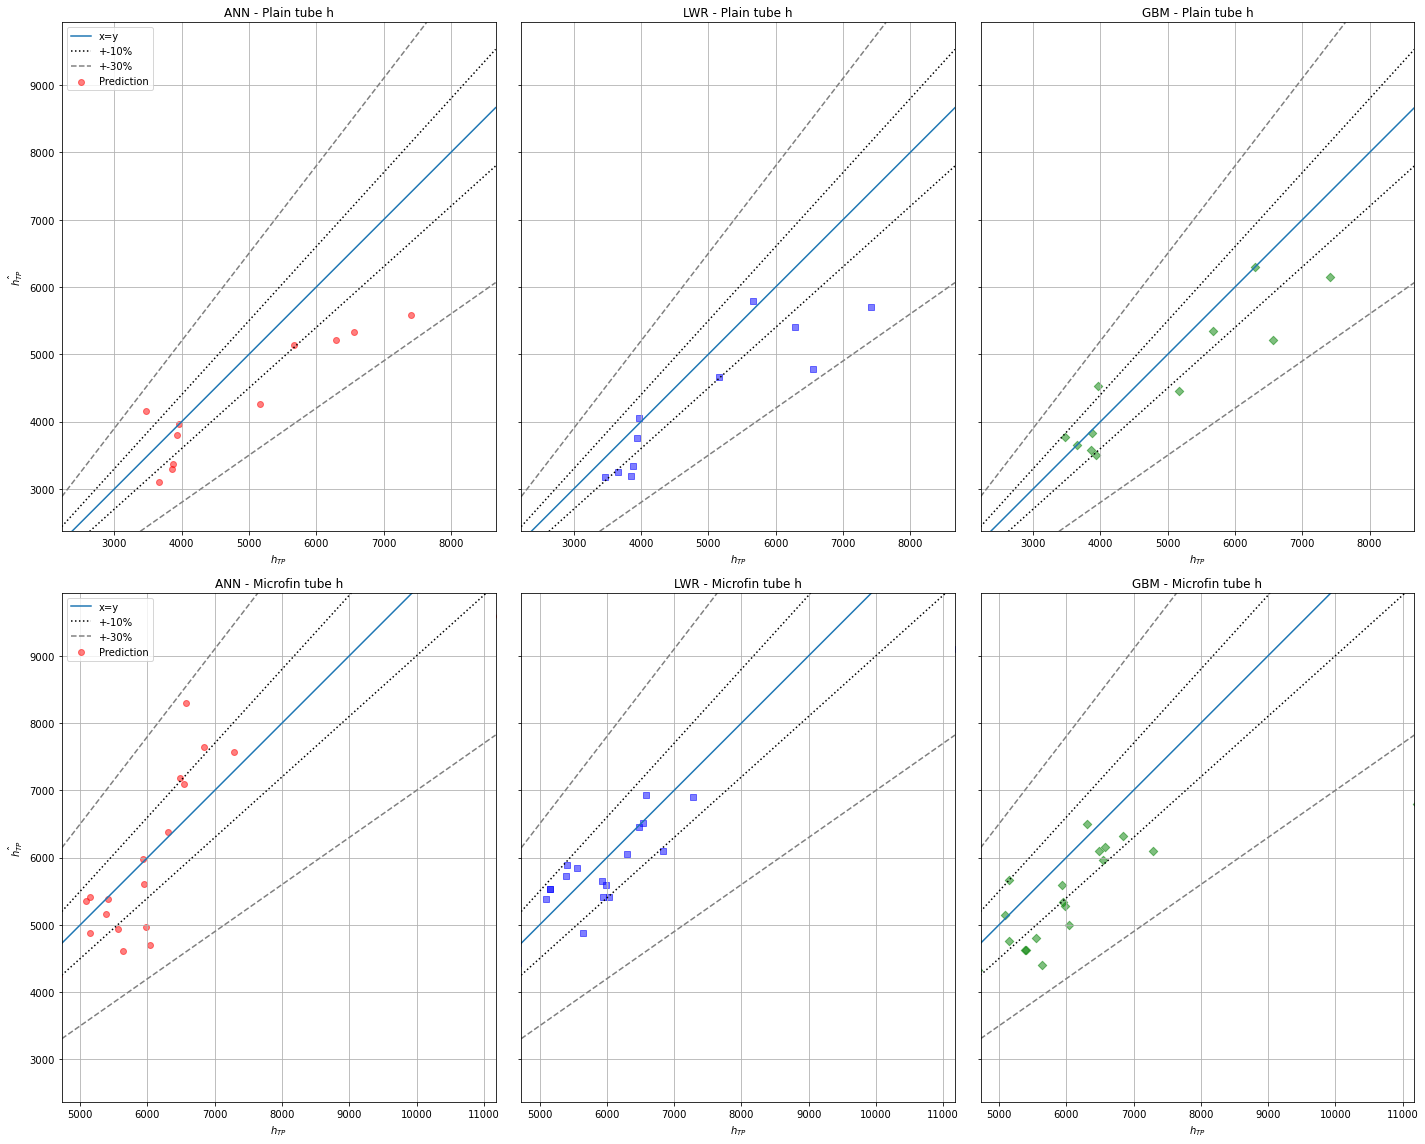

In [29]:
extra_htp.plot_predictions()

## $\Delta$ P

In [30]:
extra_dp = u.OutlierDataset(data=data_dp, X=Xdp, y=ydp)
extra_dp.setRenameFunc(u.renameDP)
extra_dp.setColNames(u.DP_NAMES)
extra_dp.setDec(u.getDecPipeline())
extra_dp.decompose()
extra_dp.setClusterer(u.getClusterer())
extra_dp.setCategories()
extra_dp.split()
extra_dp.setScoring(u.SCORING)



Visualize Outliers

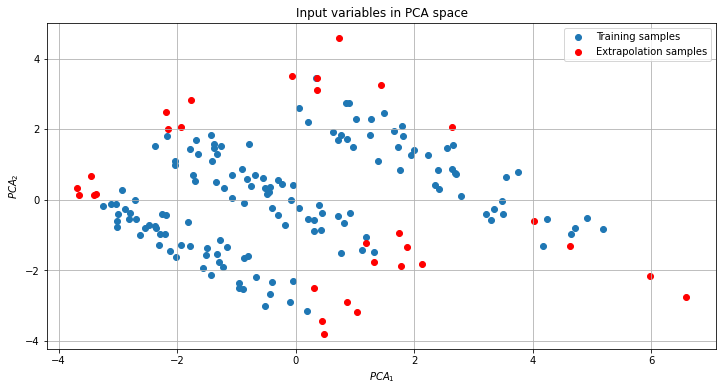

In [31]:
extra_dp.visualizeOutliers()

Fit models

In [32]:
extra_dp.addModel(u.getANN(), 'ANN')
extra_dp.addModel(u.getLwr(), 'LWR')
extra_dp.addModel(u.getGBM(), 'GBM')

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits


Test results

In [33]:
extra_dp.displayAllModelTestResults()

,ANN,LWR,GBM
R2,0.842977,0.896018,0.802648
RMSE,3077.463174,2504.318332,3450.103669
MAE,2082.035917,1475.502880,2431.064619
MAPE,0.206050,0.146356,0.236665
Bias%,0.069918,-0.039206,-0.061111
WAPE%,0.200616,0.134654,0.231981
Pearson-R,0.854801,0.912649,0.860786


Prediction Plots

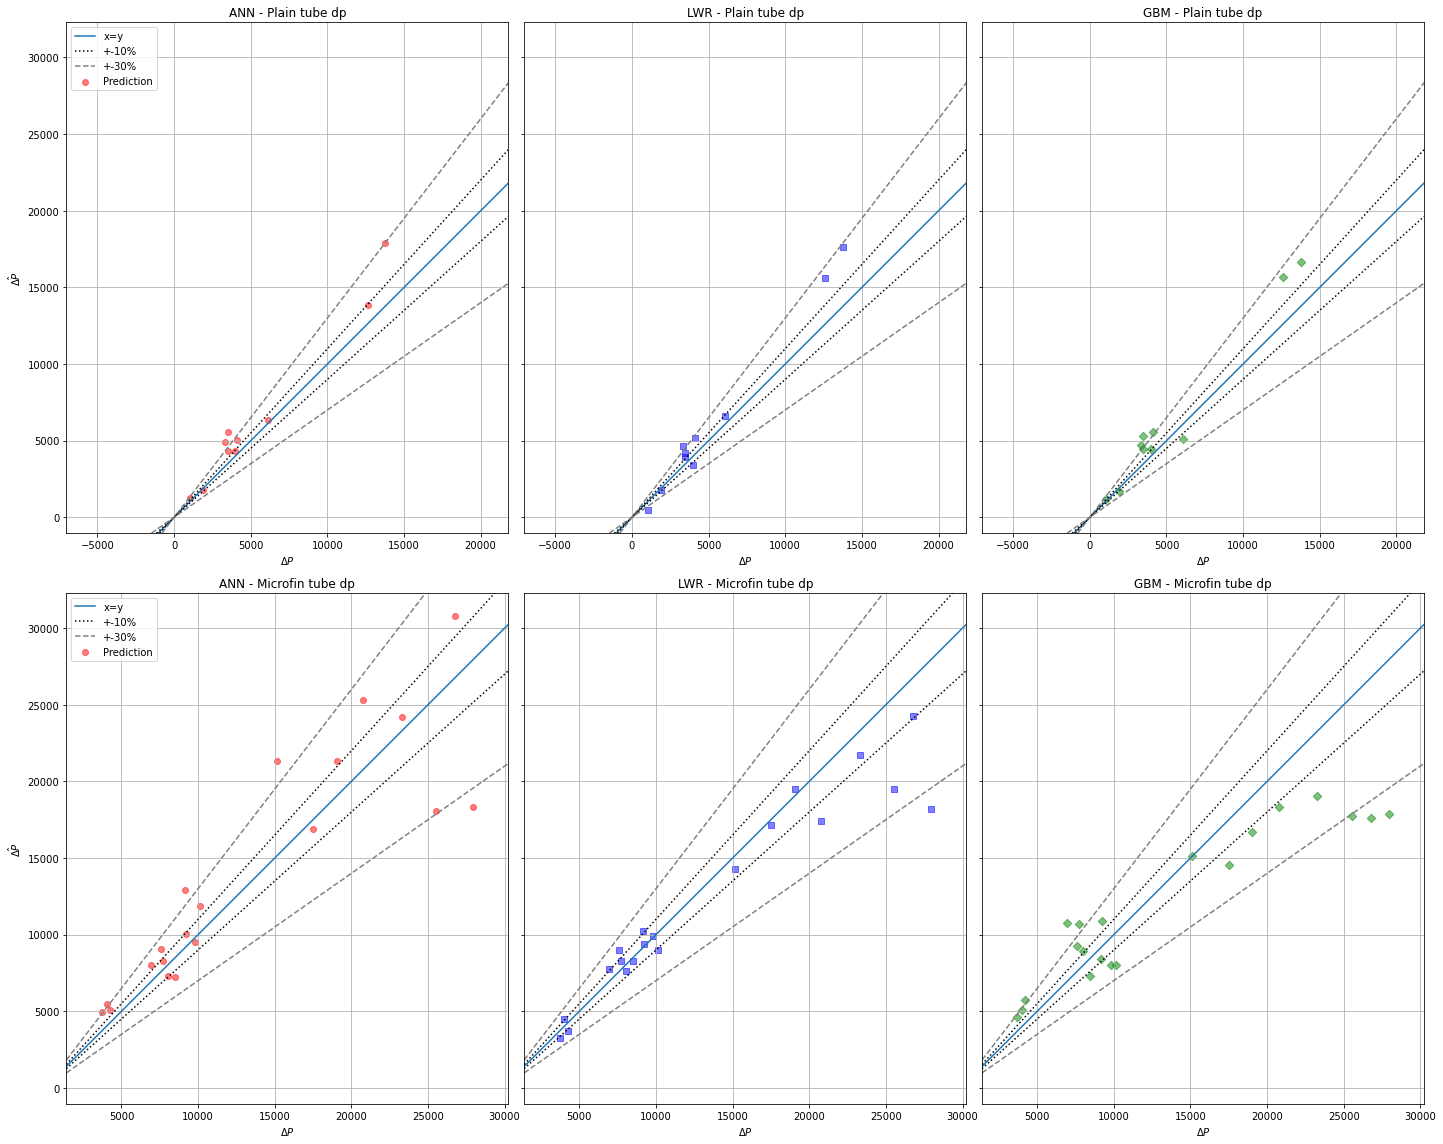

In [41]:
extra_dp.plot_predictions(target_label='\Delta P')

In [35]:
print("Complete")

Complete
